# Convolutional Neural Network

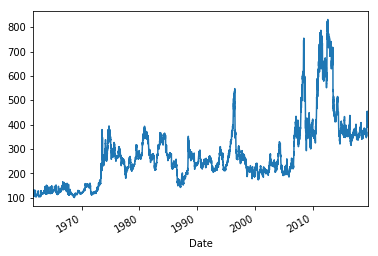

In [2]:
import pandas as pd
df=pd.read_pickle('/Users/benbilly3/Desktop/資策會專題/rawMaterialPricePrediction/RM_Price/rawMaterialPrice.pickle')
twii=df.loc['cmeCorn']['Close']
twii=twii.loc['1961-08-10 ':]
# filter_std=twii.mean()+twii.std()*3
# twii=twii[twii<filter_std]
twii.plot()

## 製作features

In [3]:
import numpy as np
import tqdm
time_period = 100

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




## Reshape features and labels

In [5]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)
cnn_x

array([[[0.20622287],
        [0.20622287],
        [0.23878437],
        ...,
        [0.15557164],
        [0.17366136],
        [0.17727931]],

       [[0.24602026],
        [0.23516643],
        [0.22793054],
        ...,
        [0.90774204],
        [0.17366136],
        [0.14109986]],

       [[0.23154848],
        [0.21345876],
        [0.2170767 ],
        ...,
        [0.13748191],
        [0.13024602],
        [0.12301013]],

       ...,

       [[0.25925926],
        [0.25925926],
        [0.26157407],
        ...,
        [0.66898148],
        [0.83333333],
        [0.85185185]],

       [[0.21296296],
        [0.22222222],
        [0.2662037 ],
        ...,
        [0.8587963 ],
        [0.79398148],
        [0.81712963]],

       [[0.26388889],
        [0.30787037],
        [0.27083333],
        ...,
        [0.90277778],
        [0.99537037],
        [0.87268519]]])

## Split traning and testing data

In [6]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

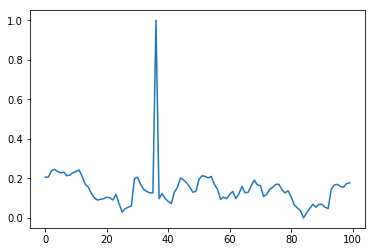

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [8]:
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 100
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(filters=10, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=240, activation='relu'))
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam, metrics=['accuracy'])

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 81, 20)            420       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 10)             2010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 10)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 240)               2640      
_________________________________________________________________
dense_2 (Dense)              (None, 120)               28920     
__________

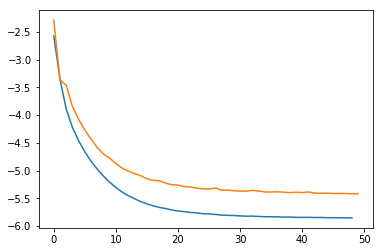

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

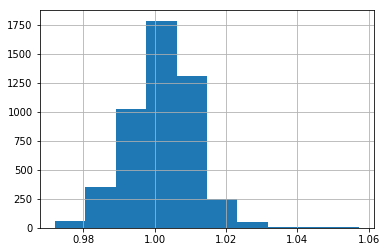

In [10]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)
ey.hist()

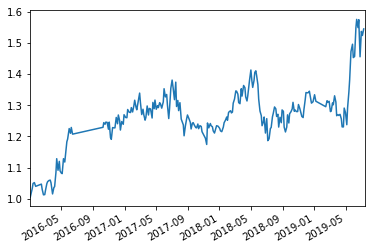

In [11]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1)/eq) 

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2016':].cumprod()
eq.plot()


In [147]:
signal['2016':].astype(int).diff().abs().sum()

10.0